## Project: Urinary biomarkers for pancreatic cancer

The original dataset is available from https://www.kaggle.com/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer

Pancreatic cancer is an extremely deadly type of cancer. Once diagnosed, the five-year survival rate is less than 10%. However, if pancreatic cancer is caught early, the odds of surviving are much better. Unfortunately, many cases of pancreatic cancer show no symptoms until the cancer has spread throughout the body. A diagnostic test to identify people with pancreatic cancer could be enormously helpful.

The goal is utlizing this dataset to predict diagnosis, and more specifically, to differentiate between 3 (pancreatic cancer) versus 2 (non-cancerous pancreas condition) and 1 (healthy). 

### In this notebook, we will focus on Pre-processing and Training Data Development.

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
# Add the dataset from a csv file
ub_data =  pd.read_csv("./archive/Debernardi et al 2020 data.csv")
print(ub_data.head())

  sample_id patient_cohort sample_origin  age sex  diagnosis stage  \
0        S1        Cohort1          BPTB   33   F          1   NaN   
1       S10        Cohort1          BPTB   81   F          1   NaN   
2      S100        Cohort2          BPTB   51   M          1   NaN   
3      S101        Cohort2          BPTB   61   M          1   NaN   
4      S102        Cohort2          BPTB   62   M          1   NaN   

  benign_sample_diagnosis  plasma_CA19_9  creatinine     LYVE1      REG1B  \
0                     NaN           11.7     1.83222  0.893219   52.94884   
1                     NaN            NaN     0.97266  2.037585   94.46703   
2                     NaN            7.0     0.78039  0.145589  102.36600   
3                     NaN            8.0     0.70122  0.002805   60.57900   
4                     NaN            9.0     0.21489  0.000860   65.54000   

         TFF1     REG1A  
0  654.282174  1262.000  
1  209.488250   228.407  
2  461.141000       NaN  
3  142.95000

In [3]:
# Call the info method on ub_data to see a summary of the data
ub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

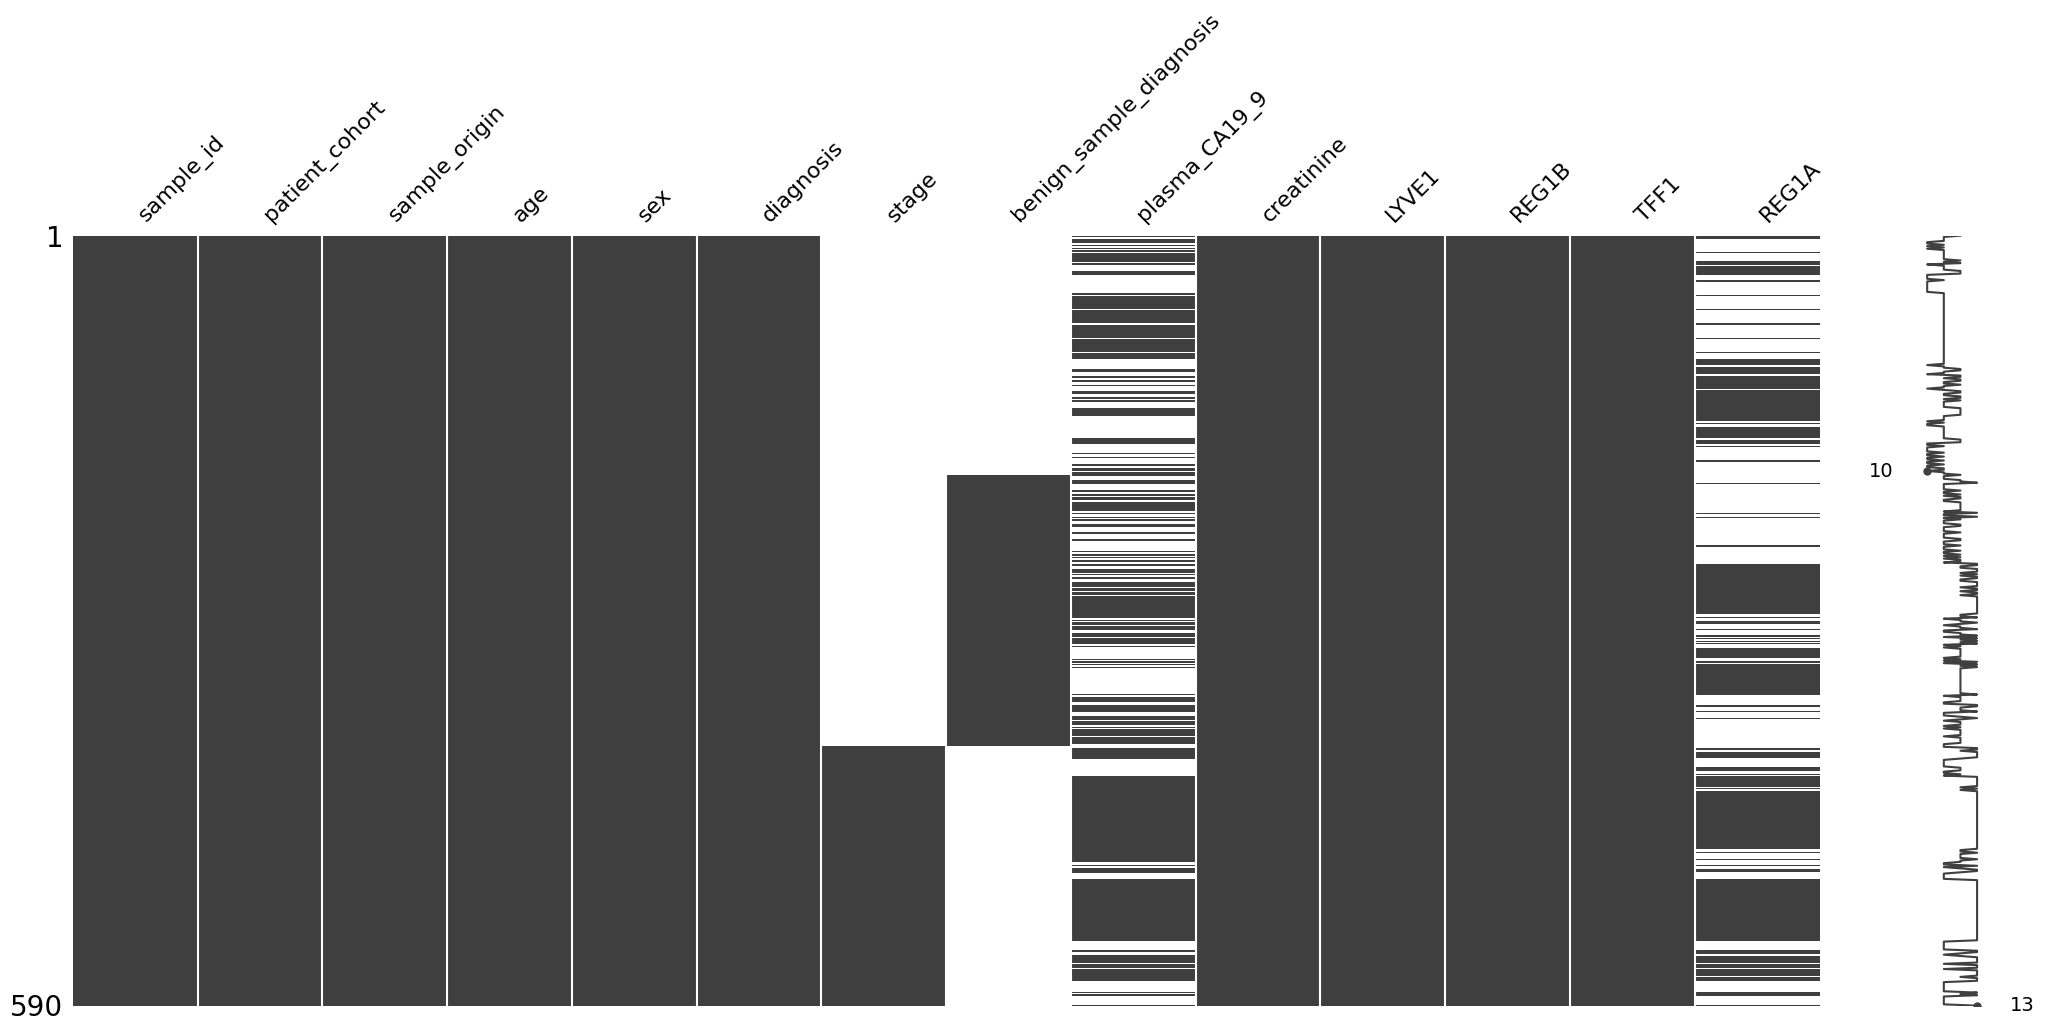

In [4]:
# Visualize missingness matrix
msno.matrix(ub_data)
plt.show()

Our target (dependent) variable is 'diagnosis'. We can see that there are lots of missing values in 'stage' and 'benign_sample_diagnosis' because only cancer patients (diagnosis #3) and those with non-cancerous pancreas (diagnosis #2) have information of 'stage' and 'benign_sample_diagnosis', respectively. However, these two columns should not be treated as predictor (independent) variables and we will remove both of them plus 'sample_id' column.

In [5]:
# Drop columns of 'sample_id', 'stage', and 'benign_sample_diagnosis'
ub_data = ub_data.drop(['sample_id','stage',"benign_sample_diagnosis"], axis=1)

### Create dummy or indicator features for categorical variables 

In [6]:
# Look into categorical variables first
ub_data_cat = ub_data.select_dtypes(include = ["object"])
print(ub_data_cat)

    patient_cohort sample_origin sex
0          Cohort1          BPTB   F
1          Cohort1          BPTB   F
2          Cohort2          BPTB   M
3          Cohort2          BPTB   M
4          Cohort2          BPTB   M
..             ...           ...  ..
585        Cohort2          BPTB   M
586        Cohort2          BPTB   F
587        Cohort2          BPTB   M
588        Cohort2          BPTB   F
589        Cohort1          BPTB   M

[590 rows x 3 columns]


As we can see, these categorical columns are all nominal data with low cardinality which can be one hot encoded later.

In [7]:
# Convert the 'sample_origin' column to a one hot encoded Data Frame
one_hot_encoded = pd.get_dummies(ub_data, columns=['sample_origin'], prefix='OH')
print(one_hot_encoded.columns)

Index(['patient_cohort', 'age', 'sex', 'diagnosis', 'plasma_CA19_9',
       'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A', 'OH_BPTB', 'OH_ESP',
       'OH_LIV', 'OH_UCL'],
      dtype='object')


In [8]:
# Create dummy variables for the 'sex' and 'patient_cohort' columnws
# Double representation (collinearity) of sex transformation using one-hot can lead instability in our model. 
# Dummy encoding is more appropriate for sex transformation!
dummy = pd.get_dummies(one_hot_encoded, columns=['sex','patient_cohort'], drop_first=True, prefix='DM')
dummy.columns.values[-1] = 'patient_cohort'
dummy.columns.values[-2] = 'sex'
print(dummy.columns)

Index(['age', 'diagnosis', 'plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B',
       'TFF1', 'REG1A', 'OH_BPTB', 'OH_ESP', 'OH_LIV', 'OH_UCL', 'sex',
       'patient_cohort'],
      dtype='object')


In [9]:
# Explore numeric data summary, pay attention to the columns with min == 0 and look into those columns.
ub_data.describe()

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,59.079661,2.027119,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,13.109520,0.804873,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,26.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,1.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,60.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,3.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,89.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


In our previous EDA, we understand that the 0s in both 'plasma_CA_9' and 'REG1A' columns were most likely the replacement of NaN. In this case, we will replace these 0s with NaN and fill all the missing values with medians of the columns.

In [10]:
# Replace 0s in both 'plasma_CA_9' and 'REG1A' columns with NaN
dummy['plasma_CA19_9'].replace(0, np.nan, inplace=True)
dummy['REG1A'].replace(0, np.nan, inplace=True)

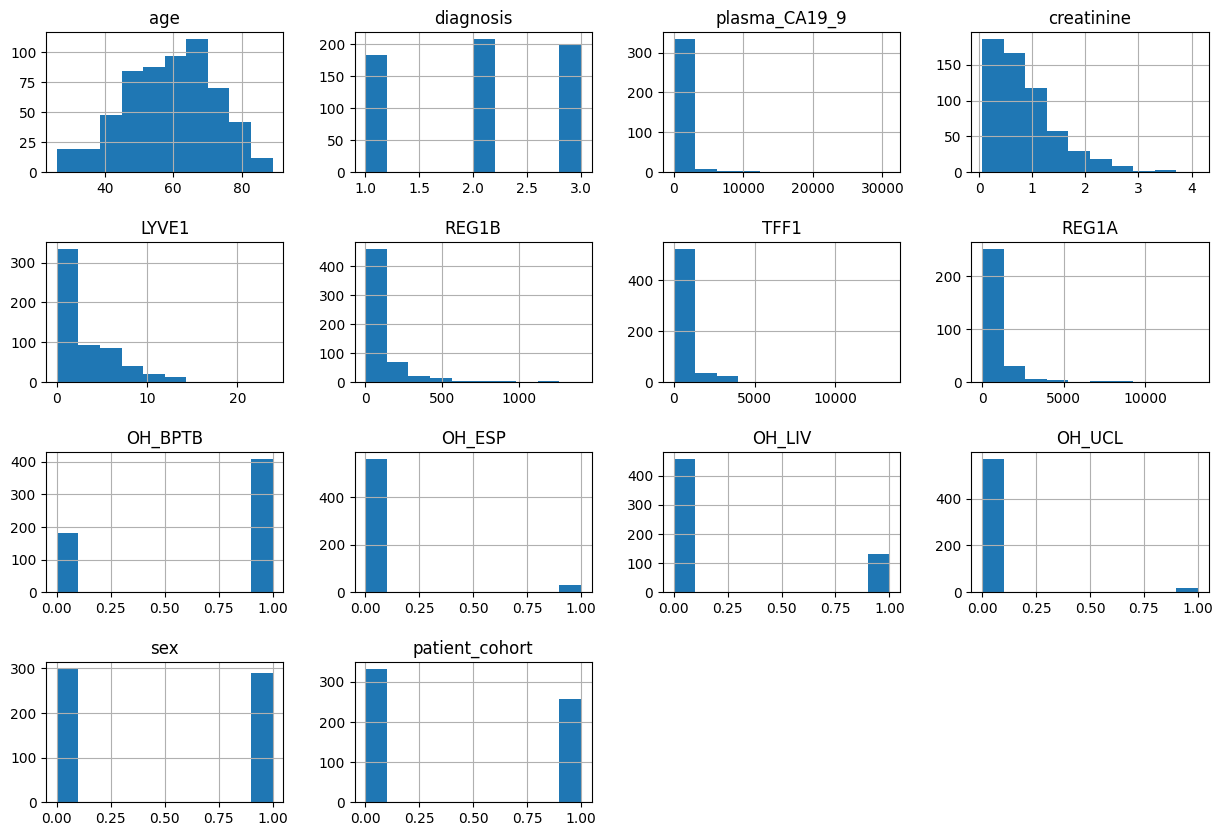

In [11]:
# Look into distributions of feature values
dummy.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

The distribution of all the six biomarkers is highly skewed towards left and have a long right tail. Thus, we will perform a log transformation after imputation. Finally, we will scale our features since most of the models, besides tree-based models, are very sensitive to unscaled features.

However, before we do any preprocessing to our data, we have to first split our data into training and test sets. **To avoid data leakage, we will only train the pipeline of preprocessing on the train set, and keep the pipeline to apply it to the test set.**

### Split into testing and training datasets 

In [12]:
# Subsetting our data into our dependent and independent variables.
y = dummy[['diagnosis']]
X = dummy.drop('diagnosis', axis=1)

# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)
X_train.head()

,age,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,OH_BPTB,OH_ESP,OH_LIV,OH_UCL,sex,patient_cohort
587,63,NaN,1.368510,7.674707,289.701000,537.286000,NaN,1,0,0,0,1,1
388,74,13.000000,0.124410,0.000498,1.295000,42.667000,NaN,1,0,0,0,0,1
49,36,5.128234,0.961350,0.019426,47.254685,19.425770,NaN,1,0,0,0,0,1
369,55,6.710000,0.390195,0.001561,1.417669,38.305367,26.407,1,0,0,0,1,0
525,73,551.000000,0.825630,5.723063,62.317864,358.934600,211.533,0,0,1,0,0,0


### Fill missing values, log-transform and standardize the magnitude of numeric features

In [13]:
# Instantiate an imputer
imputer = SimpleImputer(strategy='median')

# Instantiate a log transformer
pow_trans = PowerTransformer()

# Instantiate a scaler
scaler = StandardScaler()

# Build steps for the preprocessing pipeline
steps = [("imputer", imputer), 
         ("log_transform", pow_trans),
        ('standardization', scaler)]

# Set up pipeline
pipeline = Pipeline(steps)

# Apply fit_transform to numerical variables of X_train
X_train_num = pipeline.fit_transform(X_train.loc[:,'age':'REG1A'])

# Apply transform to numerical variables of X_test
X_test_num = pipeline.transform(X_test.loc[:,'age':'REG1A'])


In [14]:
# Recreate a DataFrame of the numeric features for X_train
X_train_num = pd.DataFrame(X_train_num, 
                          columns=X_train.columns[:7])

# Recreate a DataFrame of all the features (numerical + categorical) for X_train
X_train = pd.concat([X_train_num, X_train.loc[:,'OH_BPTB':'patient_cohort']], axis=1)
X_train.describe()

,age,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,OH_BPTB,OH_ESP,OH_LIV,OH_UCL,sex,patient_cohort
count,4.720000e+02,4.720000e+02,4.720000e+02,4.720000e+02,4.720000e+02,4.720000e+02,4.720000e+02,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000
mean,2.258081e-17,3.763468e-18,-2.822601e-17,-3.763468e-18,-7.526936e-18,-1.881734e-17,1.129040e-17,0.690678,0.048729,0.222458,0.038136,0.506356,0.455508
std,1.001061e+00,1.001061e+00,1.001061e+00,1.001061e+00,1.001061e+00,1.001061e+00,1.001061e+00,0.462705,0.215529,0.416338,0.191727,0.500490,0.498545
min,-2.385583e+00,-2.869782e+00,-1.982547e+00,-1.276282e+00,-2.302857e+00,-1.763879e+00,-4.091844e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.293366e-01,-2.570522e-01,-7.962642e-01,-1.116903e+00,-7.256439e-01,-7.342679e-01,-2.457311e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.414808e-02,-4.718101e-02,4.806227e-02,-2.616654e-02,-1.030978e-03,1.116853e-01,-2.457311e-02,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,7.511922e-01,1.937428e-01,7.369658e-01,9.497324e-01,7.550558e-01,7.593900e-01,-2.457311e-02,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,2.432822e+00,2.530007e+00,2.308148e+00,2.207955e+00,2.242418e+00,2.487761e+00,3.065335e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Likewise, recreate a DataFrame of all the features (numerical + categorical) for X_test
X_test_num = pd.DataFrame(X_test_num, 
                          columns=X_test.columns[:7])
X_test = pd.concat([X_test_num, X_test.loc[:,'OH_BPTB':'patient_cohort']], axis=1)
X_test.describe()

,age,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,OH_BPTB,OH_ESP,OH_LIV,OH_UCL,sex,patient_cohort
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,-0.033625,-0.016168,-0.120471,0.105437,-0.058436,0.143229,-0.015192,0.703390,0.050847,0.228814,0.016949,0.440678,0.364407
std,1.050139,0.890845,1.007201,0.946042,0.932591,0.926350,1.052224,0.458711,0.220623,0.421860,0.129631,0.498586,0.483316
min,-2.385583,-2.864590,-2.036791,-1.276282,-1.994219,-1.764767,-3.341821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.729337,-0.591053,-0.961153,-0.708276,-0.744138,-0.343683,-0.024573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.073315,-0.047181,-0.168012,0.143172,-0.131234,0.228604,-0.024573,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.670217,0.126053,0.680215,0.941828,0.631595,0.682887,0.326181,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,2.346097,1.923986,2.488040,1.854949,2.144996,3.139608,2.566117,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


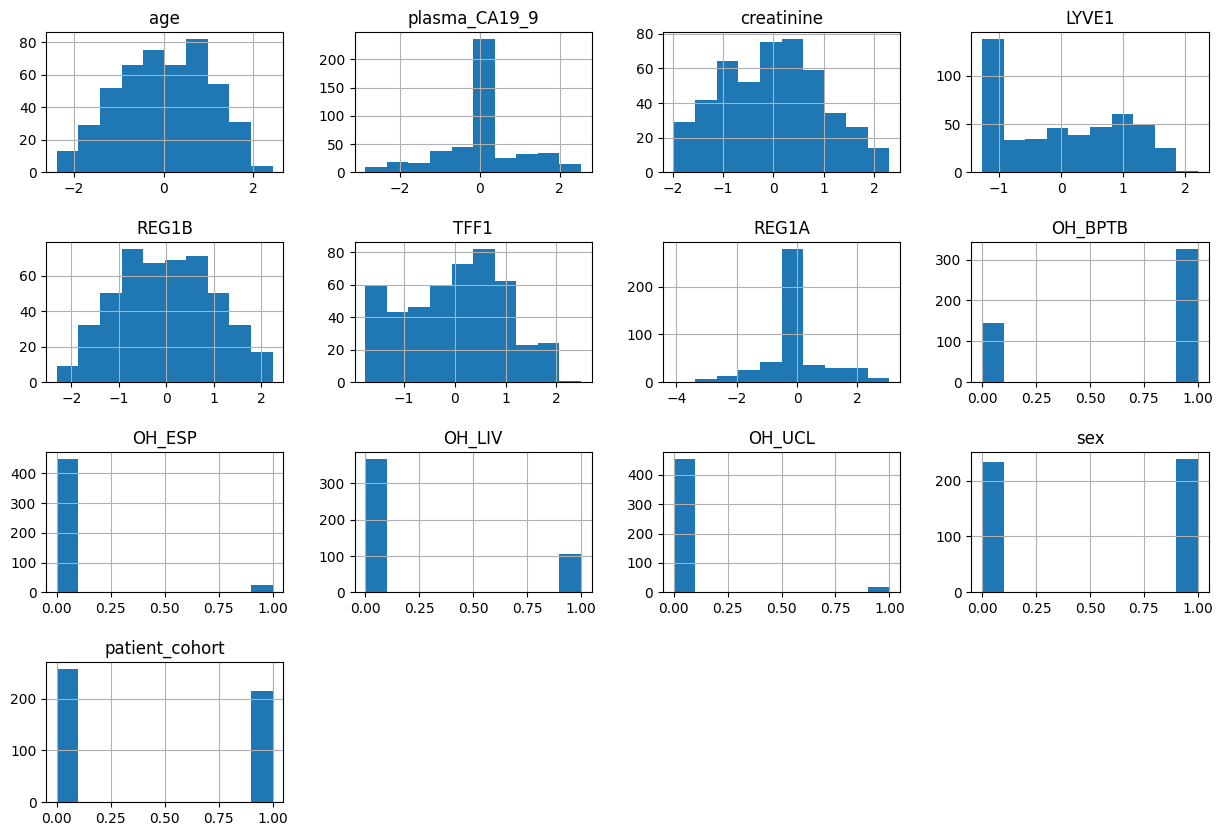

In [16]:
# Look into distributions of feature values after preprocessing
X_train.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

In [17]:
# Save the data to a new csv file for futher analysis
X_train.to_csv('./archive/X_train.csv') 
X_test.to_csv('./archive/X_test.csv')
y_train.to_csv('./archive/y_train.csv') 
y_test.to_csv('./archive/y_test.csv')